# Hourly Time Series Forecasting using Facebook's Prophet
![](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

In this notebook we will use facebook's prophet package to forecast hourly energy use. 

# Background on the Types of Time Series Data
![img](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

#import warnings
#warnings.filterwarnings("ignore")

#plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up.
 
Pulling the `PJM East` which has data from 2002-2018 for the entire east region.
 

In [2]:
pjme = pd.read_csv('../input/PJME_hourly.csv',
                   index_col=[0],
                   parse_dates=[0])

pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


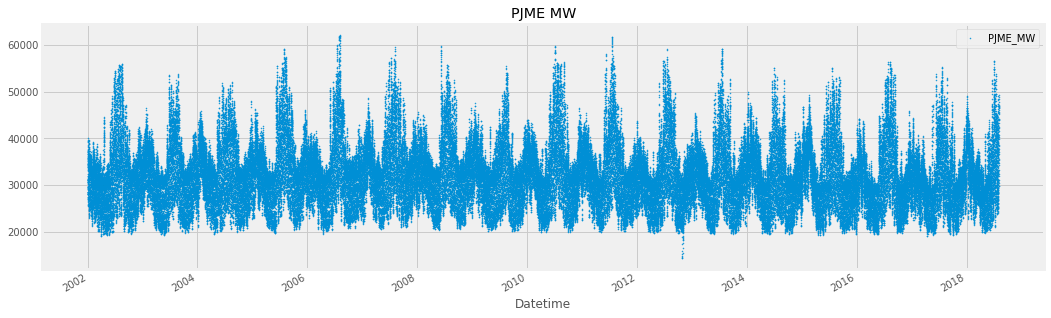

In [35]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(16, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

# Time Series Features

In [45]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday','Sunday'],
                            ordered=True)

def create_features(df_original, target):
    """
    Creates time series features from datetime index.
    """
    df = df_original.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month                # Get month number
    df['monthName'] = df['date'].dt.strftime("%B")   # Get month name
    
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    # Prepare two dataframes with just the features and the target columns
    X = df[['hour','dayofweek','quarter','month', 'monthName', 'year',
           'dayofyear','dayofmonth','weekofyear','weekday', 'season']]
    y = df[target]
    
    return X, y
    

X, y = create_features(pjme, target='PJME_MW')

features_and_target = pd.concat([X, y], axis=1) # Combine X and y into a single dataframe

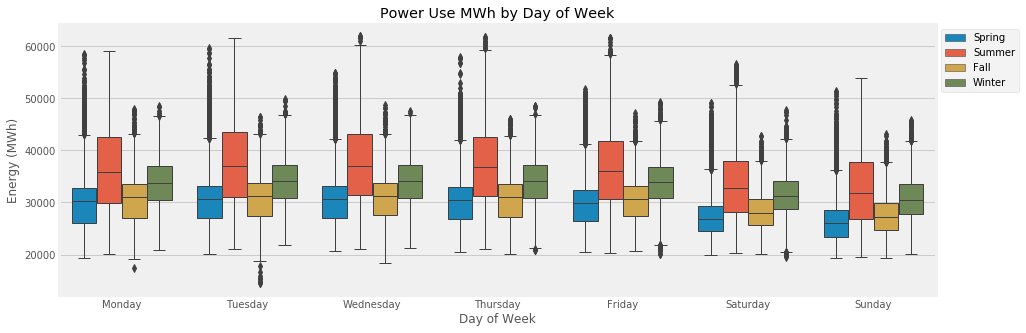

In [40]:
fig, ax = plt.subplots(figsize=(14, 5))

sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)

ax.set_title('Power Use MWh by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MWh)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Month consumption

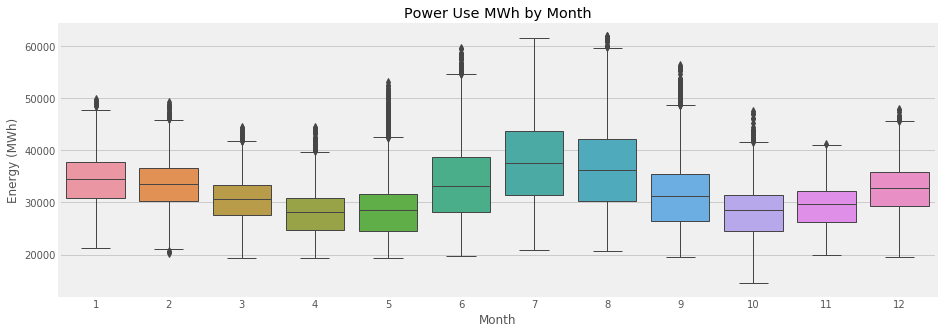

In [47]:
fig, ax = plt.subplots(figsize=(14, 5))

sns.boxplot(data=features_and_target.dropna(),
            x='month',
            y='PJME_MW',
            ax=ax,
            linewidth=1)

ax.set_title('Power Use MWh by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Energy (MWh)')
plt.show()

# Year consumption

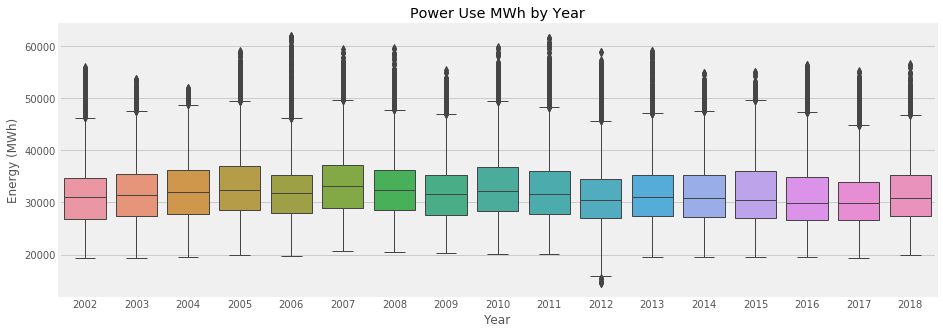

In [49]:
fig, ax = plt.subplots(figsize=(14, 5))

sns.boxplot(data=features_and_target.dropna(),
            x='year',
            y='PJME_MW',
            ax=ax,
            linewidth=1)

ax.set_title('Power Use MWh by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Energy (MWh)')
plt.show()

# Train / Test Split

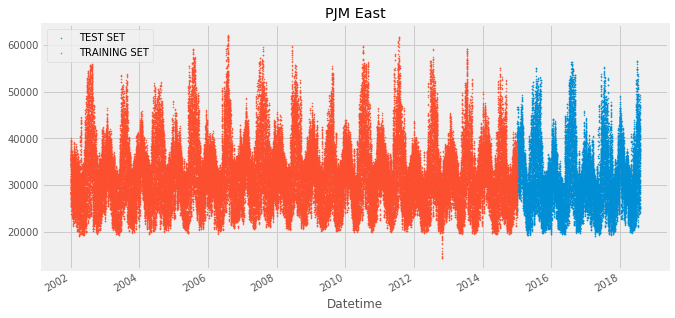

In [6]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test  = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

# Simple Prophet Model
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

In [7]:
# Format data for prophet model using ds and y (with Prophet we always need to use these names)
pjme_train_prophet = pjme_train.reset_index() \
                     .rename(columns={'Datetime':'ds',
                                      'PJME_MW':'y'})

In [8]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

CPU times: user 3min 51s, sys: 670 ms, total: 3min 51s
Wall time: 3min 52s


In [9]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
                    .rename(columns={'Datetime':'ds',
                                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [10]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31214.768254,23886.244820,32724.949625,31214.768254,31214.768254,-2864.261748,-2864.261748,-2864.261748,-4430.327494,-4430.327494,-4430.327494,1281.386957,1281.386957,1281.386957,284.678790,284.678790,284.678790,0.0,0.0,0.0,28350.506505
1,2015-01-01 02:00:00,31214.731338,22043.216381,31232.328232,31214.731338,31214.731338,-4368.619332,-4368.619332,-4368.619332,-5927.219491,-5927.219491,-5927.219491,1272.629269,1272.629269,1272.629269,285.970889,285.970889,285.970889,0.0,0.0,0.0,26846.112005
2,2015-01-01 03:00:00,31214.694422,21426.570325,30535.215120,31214.694422,31214.694422,-5240.326860,-5240.326860,-5240.326860,-6790.297120,-6790.297120,-6790.297120,1262.665752,1262.665752,1262.665752,287.304507,287.304507,287.304507,0.0,0.0,0.0,25974.367562
3,2015-01-01 04:00:00,31214.657506,21448.585591,30448.058066,31214.657506,31214.657506,-5381.914966,-5381.914966,-5381.914966,-6922.214631,-6922.214631,-6922.214631,1251.619994,1251.619994,1251.619994,288.679670,288.679670,288.679670,0.0,0.0,0.0,25832.742540
4,2015-01-01 05:00:00,31214.620591,21842.709263,30975.374351,31214.620591,31214.620591,-4707.617961,-4707.617961,-4707.617961,-6237.342157,-6237.342157,-6237.342157,1239.627794,1239.627794,1239.627794,290.096402,290.096402,290.096402,0.0,0.0,0.0,26507.002630


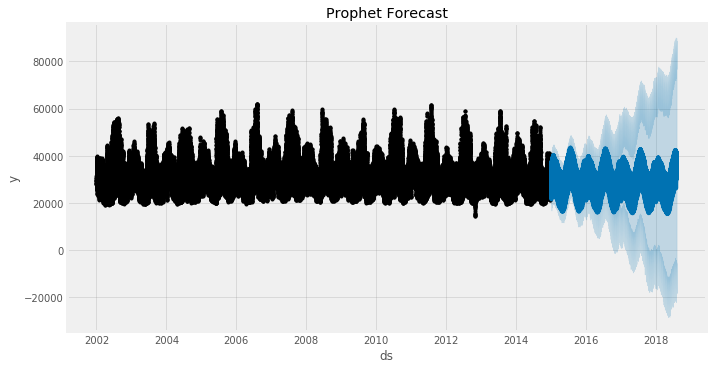

In [11]:
fig, ax = plt.subplots(figsize=(14, 5))

fig = model.plot(pjme_test_fcst, ax=ax)

ax.set_title('Prophet Forecast')
plt.show()

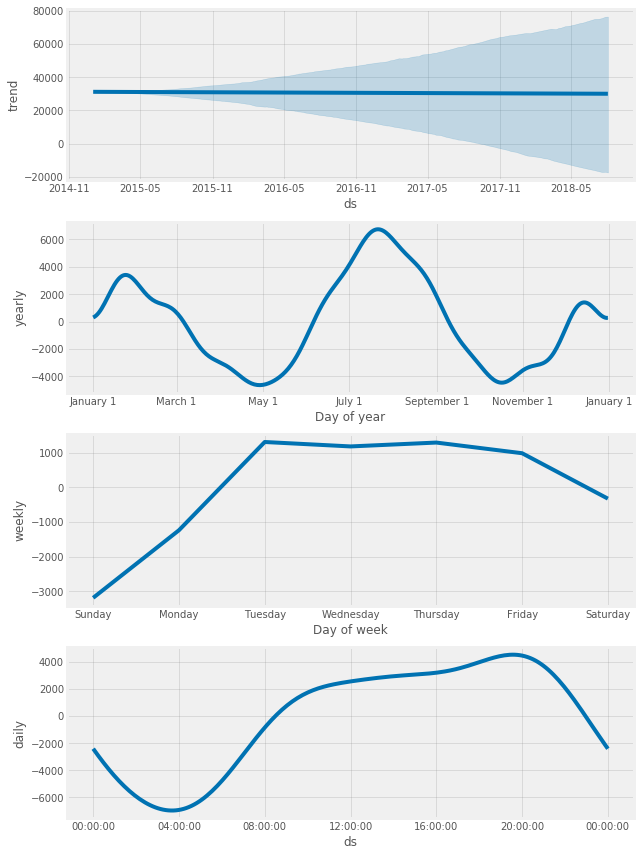

In [12]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

# Compare Forecast to Actuals

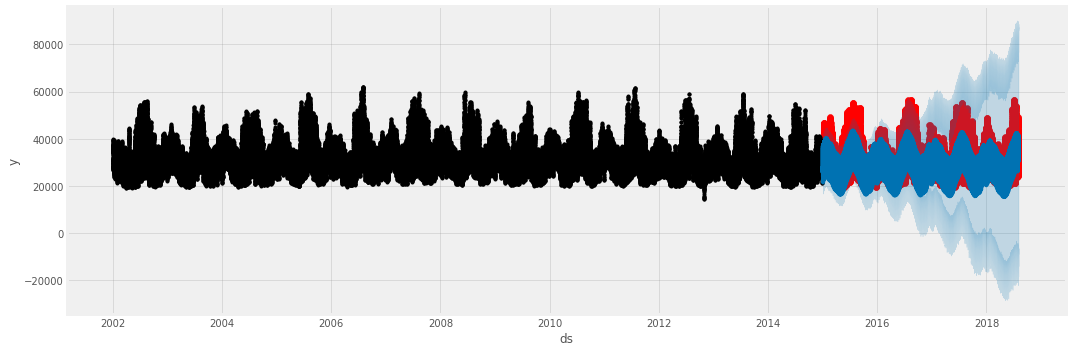

In [13]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))

ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r') # Plot real values (in red)
fig = model.plot(pjme_test_fcst, ax=ax)                      # Plot predicted values

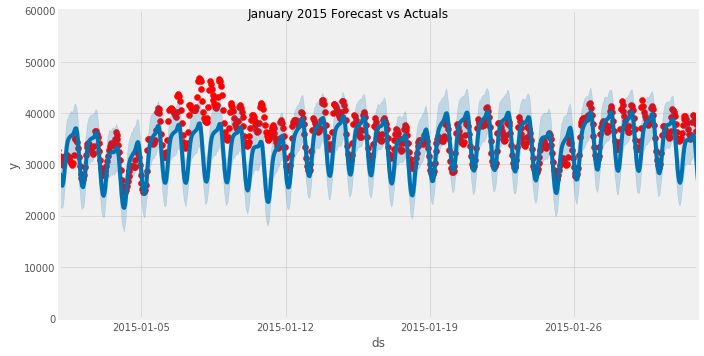

In [14]:
# Same as above, but within a single month
fig, ax = plt.subplots(figsize=(14, 5))

ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')  # Plot real values (in red)
fig = model.plot(pjme_test_fcst, ax=ax)                       # Plot predicted values

ax.set_xbound(lower='01-01-2015', upper='02-01-2015') # Set horizontal range (1 month)
ax.set_ylim(0, 60000)                                 # Set visible vertical range

plot = plt.suptitle('January 2015 Forecast vs Actuals')

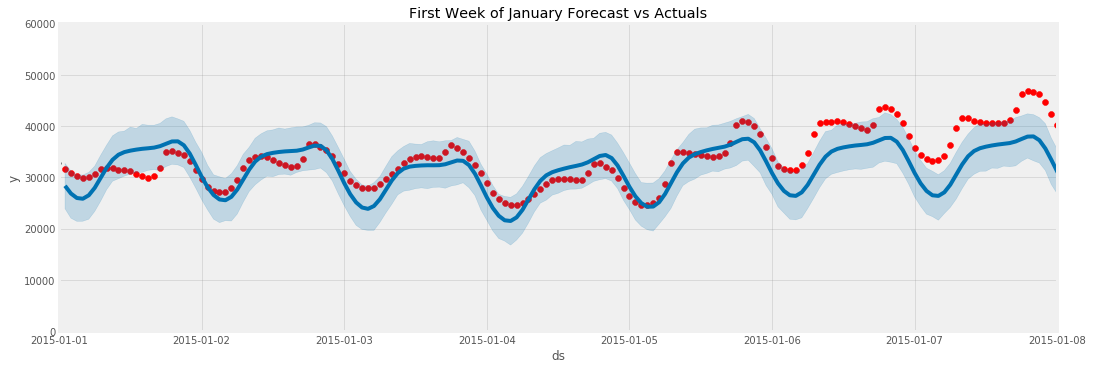

In [15]:
# Same as above, but within a single week
f, ax = plt.subplots(figsize=(15, 5))

ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)

ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

# Evaluate the model with Error Metrics

In [16]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                           y_pred=pjme_test_fcst['yhat']))

6615.260772757282

In [17]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcst['yhat'])

5181.782050398612

In [18]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst['yhat'])

16.512109913326153

# Adding Holidays

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [20]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

CPU times: user 2min 58s, sys: 662 ms, total: 2min 59s
Wall time: 2min 59s


In [21]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

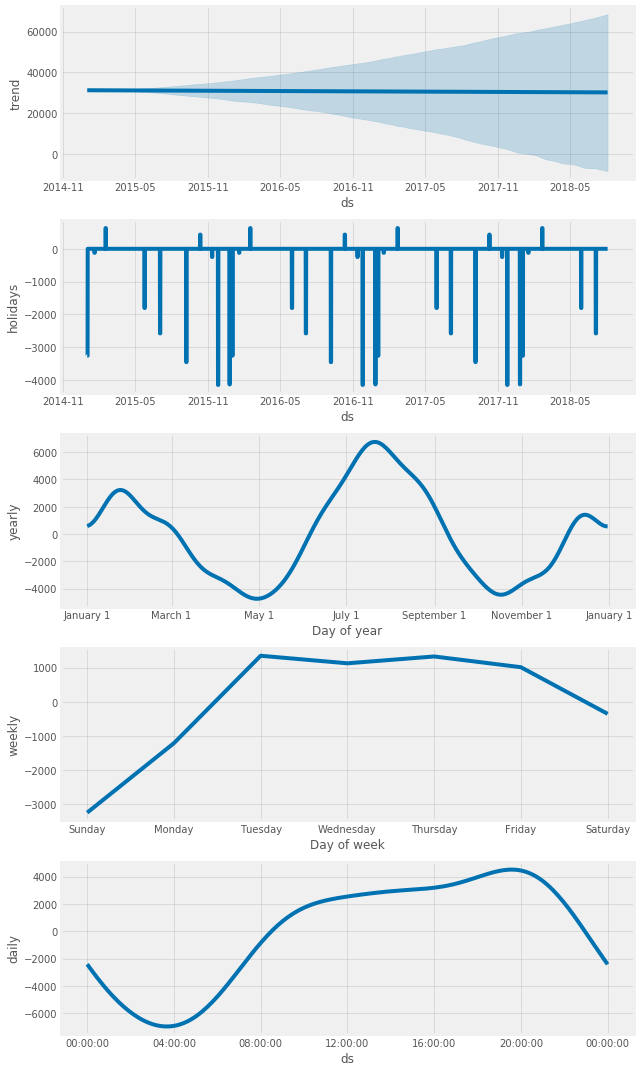

In [22]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

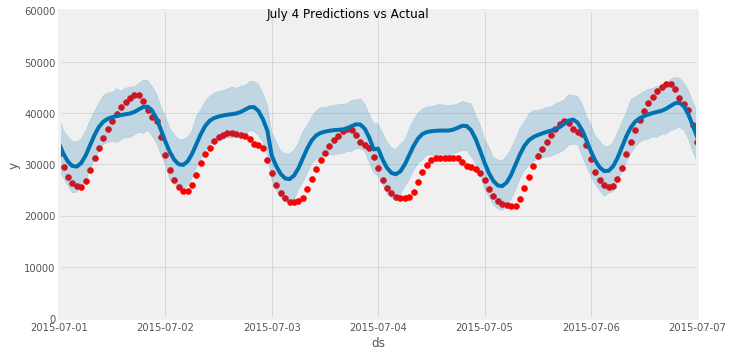

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='07-01-2015',
              upper='07-07-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [24]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                           y_pred=pjme_test_fcst_with_hols['yhat']))

6629.892998280289

In [25]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcst_with_hols['yhat'])

5195.461156992755

In [26]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst_with_hols['yhat'])

16.580177835038022

# Predict into the Future

We can use the built in `make_future_dataframe` method to build our future dataframe and make predictions.

In [27]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [28]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25501.763125
1,2015-01-01 02:00:00,23999.616910
2,2015-01-01 03:00:00,23129.990868
3,2015-01-01 04:00:00,22990.389422
4,2015-01-01 05:00:00,23666.419956


# The End